In [1]:
#This project was largely a learning opportunity to understand compromises between Domain-based inferences and model building
#The flow of the project will explain the train of thought to justify use of specific features for further model building,
#and defend the use of new features made on the way.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
#ensemble
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#warnings
import warnings
warnings.filterwarnings("ignore")

In [117]:
df = pd.read_csv("../../data/raw_datasets/new_data/L&T auto loans/train.csv")

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)


In [118]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade', 'Employment.Type'],axis=1)

In [119]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [120]:
df = df[df["Age"] <= 23]

In [121]:
numerical=['disbursed_amount','asset_cost','PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','Age','NEW.ACCTS.IN.LAST.SIX.MONTHS', 
        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
       'Employment Type']

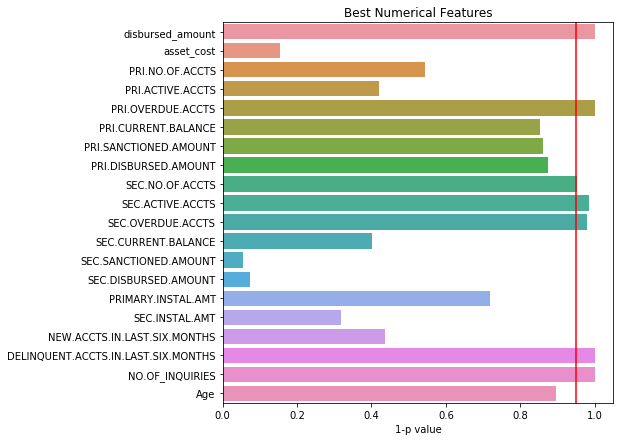

In [43]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

For visual purpose, I redid the graph to show acceptance of 'Alternative Hypothesis' for T Test. So, the ones crossing the red lines show
statistical significance. But for vehicle loans and educational loans, it is observed that Banks don't want to compromise of loosing any 
details of Secondary Account holder, since them also being the guarantor for the loan in case of a default.
But, there is a problem in this T Test, as will be observed in the next cell


In [44]:
for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    print(np.std(df1[i],ddof=1),np.std(df2[i],ddof=1))

13538.968784216608 12729.31991453207
21013.34172676075 20804.700257025946
2.462544939772222 2.1414178000252306
0.9902071630035132 1.0173375985594677
0.20753906273865533 0.2806398929730567
285167.88480959175 229279.5787894089
319680.23981912184 269400.665546263
323954.4718099778 269218.4619485258
0.37156707525542015 0.4987425672165538
0.1983618697824021 0.3071892894529555
0.06133795247627345 0.08832939364610803
49661.0838094135 62267.289830449605
103865.67235560318 82271.7843159634
103436.1875060231 81390.12562911955
99667.52704855462 37988.323519681675
3493.5931875253345 3338.6750592326666
0.6252062589570329 0.6918406929157946
0.2114408247284026 0.27221905288261805
0.5349649525901302 0.6459594371783997
1.223732599038434 1.2297491959508289
0.6252062589570329 0.6918406929157946
0.2114408247284026 0.27221905288261805


The above observations are Standard Deviations of Columns (i.e., Defaulters vs Non-defaulters). T Test for independence runs on the assumption that samples under observations should have equal Standard Deviations. Although the difference observed above seems less, it still doesn't seem acceptable. Hence, we'll go with a non-parametric test.

We'll use SelectKBest library to narrow down choices of features. This will make use of Annova test.

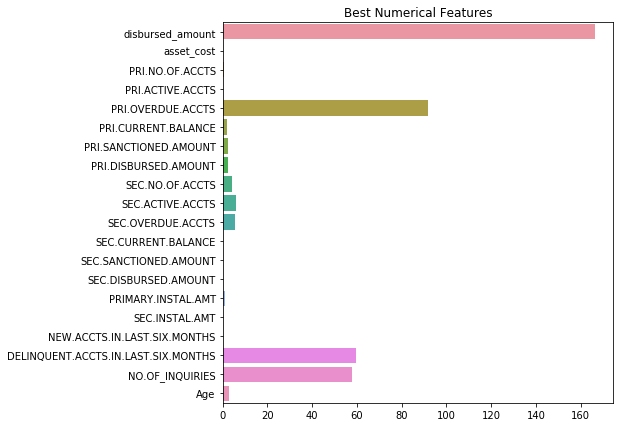

In [45]:
from sklearn.feature_selection import SelectKBest,f_classif
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[numerical],df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

The graph shows that Secondary Account informations are insignificant. Again of course, banks can't afford to drop Secondary Account informations, so we'll have to combine the Primary and Secondary Account informations. 

In [122]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

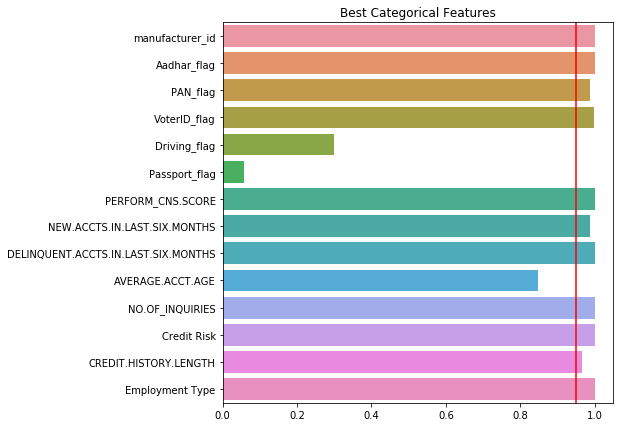

In [47]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

Here too, the graph shows acceptance of Alternate Hypothesis. Again, we can observe some multicollinearity between credit score and PAN Card,
since PAN Card is mandatory to obtain credit score. Hence, the Chi Square test deemed it surplus to our research. But for argument sake, we'll
keep it.

In [123]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [124]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [125]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [126]:
df

,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,Credit Risk,Employment Type,Age,No of Accounts,Total Inactive accounts,Total Overdue Accounts,Total Current Balance,Total Sanctioned Amount,Total Disbursed Amount,Total Installment
33,60630,72.57,45,1,0,0,0,0,0,0,...,-1,0,22,0,0,0,0,0,0,0
39,58400,89.55,45,1,0,0,0,0,0,0,...,-1,1,22,0,0,0,0,0,0,0
56,62413,84.60,45,1,0,0,0,0,762,0,...,12,1,23,3,2,0,2412,36920,36920,0
64,63000,82.54,45,1,0,0,0,0,0,0,...,-1,1,23,0,0,0,0,0,0,0
71,63840,68.92,45,1,0,0,0,0,0,0,...,-1,1,23,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233086,70055,88.93,45,0,1,1,0,0,0,0,...,-1,1,23,0,0,0,0,0,0,0
233105,68791,79.81,45,0,1,1,0,0,0,0,...,-1,0,23,0,0,0,0,0,0,0
233108,93396,68.00,120,0,1,1,0,0,0,0,...,-1,0,22,0,0,0,0,0,0,0
233135,60334,66.30,48,0,0,1,0,0,0,0,...,-1,1,22,0,0,0,0,0,0,0


In [88]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment','Age']

In [89]:
len(nums)

16

In [18]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



Now this is a bad start to model building. The model isn't able to predict the 1s here. Maybe class-imbalance here. Plus, there is huge difference between macro and weighted scores. So, lets see the distribution of the target variable.

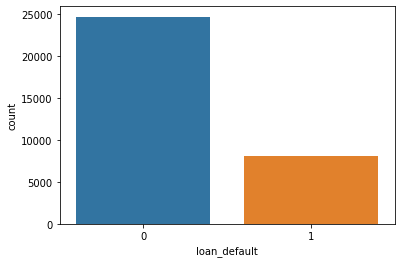

In [18]:
sns.countplot(df['loan_default'])

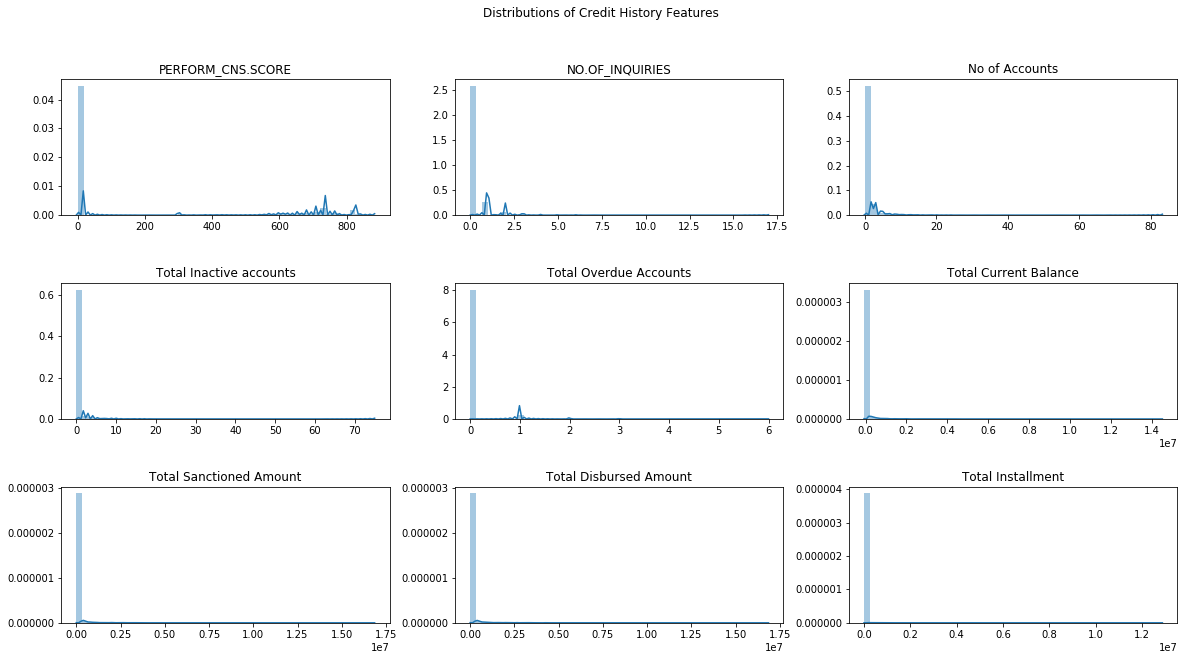

In [19]:
n=['PERFORM_CNS.SCORE','NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment']
data=df[n]
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()

Maximum number of customers are applying for loan for the first time, which explains why all the above columns have so many zero values. Also, there are many notable outliers, which makes the problem more complicated.

Let's deal with outliers. Instead of using popular methods, we'll try to preserve the outlier records instead of removing them. We'll use RobustScaler to bring the observations closer to the median value (here, zero in those credit history columns).

In [93]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

Now, for the zero observations, we'll make a new feature that counts the features having zero. This will act as yardstick between people who have a credit history and those who dont. Of course, people with no credit history will likely have more than 9 features as zero, unlikely in case of customers with credit history.

In [94]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

Now let's try on our base model. We'll use XGBoost to reduce bias and variance errors, and do some hyperparameter tuning.

In [55]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [56]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [ ]:
param_test2b = {
 'max_depth':range(7,10,2)
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch2b.fit(X_train,y_train)

In [ ]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

In [26]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [27]:
xgb4.fit(X_train,y_train)
y_pred=xgb4.predict(X_test)
print("accuracy train:",xgb4.score(X_train,y_train),"\n")
print("accuracy test:",xgb4.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.9999563223411225 

accuracy test: 0.9859370223173342 

precision : 0.9895788102475033 

Recall : 0.9523610530714585 

f1 score: 0.9706132879045997 

Confusion Matrix 
 [[7396   24]
 [ 114 2279]]


In [57]:
from sklearn.ensemble import RandomForestClassifier
SEED = 42
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 20, 
                            min_samples_leaf = 50)

rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

print("accuracy train:",rf.score(X_train,y_train),"\n")
print("accuracy test:",rf.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.8876610613671108 

accuracy test: 0.8767960868236013 

precision : 0.6901091843288375 

Recall : 0.8980359381529461 

f1 score: 0.7804612311603414 

Confusion Matrix 
 [[6455  965]
 [ 244 2149]]



Model Report
AUC Score (Test): 0.998899
[[7396   24]
 [ 114 2279]]


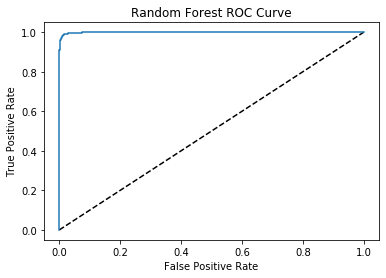

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      7510
        True       0.95      0.99      0.97      2303

    accuracy                           0.99      9813
   macro avg       0.97      0.99      0.98      9813
weighted avg       0.99      0.99      0.99      9813



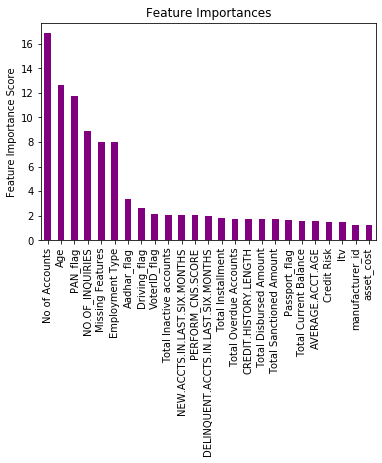

In [31]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, classification_report, r2_score


def get_roc_curve(model, treshold, y_test, y_pred_prob):
    
    plt.figure()
   
    fpr, tpr, tresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label = "random forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curve")
    plt.savefig("Roc_curve")
    plt.show()
    
def get_classification_table(y_pred, y_val_or_test):
    
    print(classification_report(y_val_or_test, y_pred))
    

def evaluate_xgboost_model(alg, X_test, y_test, threshold):
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    dtrain_predictions_thresh = alg.predict_proba(X_test)[:, 1] >= threshold
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob))
    print(confusion_matrix(y_test, dtrain_predictions_thresh))
    
    get_roc_curve(alg, threshold, y_test, dtrain_predprob)
    
    get_classification_table(y_test, dtrain_predictions_thresh)
    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).iloc[:40]
    feat_imp.plot(kind='bar', title='Feature Importances',  color = "purple")
    plt.ylabel('Feature Importance Score')
    
evaluate_xgboost_model(xgb4, X_test, y_test, 0.5)

Voila! we smashed the record set on all these scores.

In [ ]:
import sklearn.metrics as metrics

In [ ]:
probs = xgb4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

In [ ]:
print(fpr, tpr)

In [ ]:
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

In [ ]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb4.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()